In [1]:
import pandas as pd
import scipy.stats as st
import numpy as np
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, average_precision_score, f1_score
from sklearn.model_selection import RepeatedKFold
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import ssl

warnings.filterwarnings('ignore')
ssl._create_default_https_context = ssl._create_unverified_context

Load TNBC samples:

In [2]:
pinfo = pd.read_csv('../../masked/patients_info.csv', index_col=0).sort_index()

pinfo['T'] = pinfo['T']>'T2'
pinfo['N'] = pinfo['N']>'N0'

meth = pd.read_csv('../../masked/meth.csv', index_col=0)
rna = (pd.read_csv('../../masked/rna.csv', index_col=0)+0.01).applymap(np.log2)
ssrna = pd.read_csv('../../masked/ssrna.csv', index_col=0)
dia = pd.read_csv('../../masked/dia.csv', index_col=0)
pp = pd.read_csv('../../masked/pp.csv', index_col=0)

df_tnbc = pinfo.loc[(pinfo['HER2_Status']=='Neg') & (pinfo['ER_Status']=='Neg')]

df_tnbc['Ki67'] = st.zscore(df_tnbc['Ki-67'], nan_policy='omit')
df_tnbc['CDKN2A_meth'] = st.zscore(df_tnbc.index.map(meth['NM_001195132']), nan_policy='omit')
df_tnbc['HM_E2F_rna'] = st.zscore(df_tnbc.index.map(ssrna['HALLMARK_E2F_TARGETS']), nan_policy='omit')
df_tnbc['TOP2A_dia'] = st.zscore(df_tnbc.index.map(dia['TOP2A']), nan_policy='omit')
df_tnbc['TOP2A_pp'] = st.zscore(df_tnbc.index.map(pp['TOP2A']), nan_policy='omit')
df_tnbc['TOP2A_rna'] = st.zscore(df_tnbc.index.map(rna['TOP2A']), nan_policy='omit')

df_tnbc = df_tnbc[['pCR','T','N','Ki67','CDKN2A_meth','HM_E2F_rna','TOP2A_dia','TOP2A_pp','TOP2A_rna',]].astype(float)

In [3]:
df_transneo = pd.read_csv('./results/transneo_clin_tn.NN.prediction.csv', index_col=0)
df_transneo['pCR'] = df_transneo.index.map(pd.read_csv('./data/transneo_clin_tn.csv', index_col=0)['resp.pCR'])

In [4]:
df_tcga = pd.read_csv('./results/tcga_clin_tn.NN.prediction.csv', index_col=0)
df_tcga

,MONTHS,STATUS,T,N,Ki67,CDKN2A_meth,HM_E2F_rna,TOP2A_dia,TOP2A_pp,Pr
Patient.ID,,,,,,,,,,
TCGA-D8-A13Z,20.86,0.0,0.0,1.0,1.228393,NaN,0.495712,0.156860,0.156860,0.489860
TCGA-D8-A143,14.16,0.0,0.0,0.0,1.100903,NaN,1.240850,1.410084,1.410084,0.881925
TCGA-OL-A5D6,NaN,NaN,0.0,0.0,-2.101174,0.592536,-2.599952,-3.314556,-3.314556,0.181241
TCGA-C8-A26Y,12.94,0.0,0.0,0.0,0.296804,0.464771,-0.203256,0.334677,0.334677,0.571009
TCGA-C8-A26X,12.35,0.0,0.0,1.0,-0.856820,2.308558,-0.261959,-1.722636,-1.722636,0.078605
...,...,...,...,...,...,...,...,...,...,...
TCGA-AR-A2LR,57.23,0.0,0.0,0.0,-0.238046,-0.644536,0.455753,0.791122,0.791122,0.881925
TCGA-AO-A03U,53.02,1.0,0.0,0.0,-0.935142,0.638892,-2.156330,-1.273608,-1.273608,0.181241
TCGA-BH-A42U,110.51,0.0,0.0,0.0,-4.263089,2.053300,-2.770636,-3.908323,-3.908323,0.181241


In [5]:
df_train = df_tnbc.copy()

100-repeated 5-fold cross-validation:

In [6]:
kf = RepeatedKFold(n_splits=5, n_repeats=100, random_state=1)

fs = {}
fs['clin'] = 'T	N	Ki67'.split('\t')
fs['omics'] = 'T	N	Ki67	CDKN2A_meth	HM_E2F_rna	TOP2A_dia	TOP2A_pp'.split('\t')
fs['single.meth'] = 'CDKN2A_meth'.split('\t')
fs['single.rna'] = 'HM_E2F_rna'.split('\t')
fs['single.prot'] = 'TOP2A_dia	TOP2A_pp'.split('\t')

aucs = {}
aps = {}
for n_est in [50,100,200]:
    for l_rate in [0.05,0.1,0.2]:
        aucs[(n_est, l_rate)] = {}
        aps[(n_est, l_rate)] = {}
        for f in fs.keys():
            aucs[(n_est, l_rate)][f] = []
            aps[(n_est, l_rate)][f] = []
    
for n_est in [50,100,200]:
    for l_rate in [0.05,0.1,0.2]:
        for train_index, test_index in kf.split(df_train):
            X_train, X_test = df_train.drop(columns='pCR').iloc[list(train_index)], df_train.drop(columns='pCR').iloc[list(test_index)]
            y_train, y_test = df_train['pCR'].iloc[list(train_index)], df_train['pCR'].iloc[list(test_index)]
            if y_train.unique().shape[0]==2 and y_test.unique().shape[0]==2:
                for f in fs.keys():
                    model = lgb.LGBMClassifier(random_state=1, n_estimators=n_est, learning_rate=l_rate)
                    model.fit(X_train[fs[f]], y_train)
                    X_test[f] = [i[1] for i in model.predict_proba(X_test[fs[f]])]
                    aucs[(n_est, l_rate)][f].append(roc_auc_score(y_test,X_test[f]))
                    aps[(n_est, l_rate)][f].append(average_precision_score(y_test,X_test[f]))
                
def best_params(res, fs):
    best_pdict = {}
    for i in fs:
        best_pdict[i] = pd.DataFrame(res).applymap(sum).T.sort_values(i).index[-1]
    return pd.concat([pd.DataFrame(res[best_pdict[i]]).melt().loc[pd.DataFrame(res[best_pdict[i]]).melt()['variable']==i] for i in fs])

Compare clinical model and multi-omics model:

Best params for clin model:
# of trees: 200 
Learning rate: 0.05
0.6124818253968254

Best params for omics model:
# of trees: 100 
Learning rate: 0.05
0.7386717857142857

Best params for single.meth model:
# of trees: 50 
Learning rate: 0.05
0.6944692857142858

Best params for single.rna model:
# of trees: 50 
Learning rate: 0.05
0.6083534126984127

Best params for single.prot model:
# of trees: 50 
Learning rate: 0.05
0.6846246031746032


Best params for clin model:
# of trees: 200 
Learning rate: 0.05
0.5930560034013607

Best params for omics model:
# of trees: 100 
Learning rate: 0.05
0.7426775391671819

Best params for single.meth model:
# of trees: 200 
Learning rate: 0.05
0.6476820759751711

Best params for single.rna model:
# of trees: 50 
Learning rate: 0.2
0.5742336652236651

Best params for single.prot model:
# of trees: 100 
Learning rate: 0.05
0.6745549625220458


winner vs runnerup:
RanksumsResult(statistic=-4.841090635534367, pvalue=1.2912845614554638e-06)
(0.694469285714

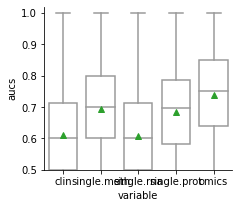

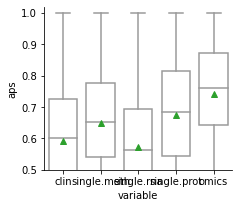

In [7]:
for m in [aucs, aps]:
    for i in fs.keys():
        print('Best params for '+i+' model:')
        print('# of trees:',pd.DataFrame(m).applymap(sum).T[i].idxmax()[0], '\nLearning rate:',pd.DataFrame(m).applymap(sum).T[i].idxmax()[1])
        df = best_params(m, [i,])
        print(df[df['variable']==i]['value'].mean())
        print()
    print()

res_dict = {
    'aucs':aucs,
    'aps':aps,
}

for resi in res_dict.keys():
    res = res_dict[resi]
    winner = best_params(res, ['clin','single.meth','single.rna','single.prot','omics']).groupby('variable').mean().sort_values('value').index[-1]
    runnerup = best_params(res, ['clin','single.meth','single.rna','single.prot','omics']).groupby('variable').mean().sort_values('value').index[-2]
    df = best_params(res, [runnerup,winner,])
    
    f, ax = plt.subplots(figsize=[1.35*2.5,3])
    df = best_params(res, ['clin','single.meth','single.rna','single.prot','omics'])
    sns.boxplot(df['variable'], df['value'], color='#ffffff', width=0.75, showmeans=1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.ylim([0.5,1.02])
    plt.ylabel(resi)
    plt.savefig('../figures/training_cv_'+resi+'_tn_combined.pdf', bbox_inches='tight')

    print('winner vs runnerup:')
    print(st.ranksums(df[df['variable']==runnerup]['value'], df[df['variable']==winner]['value']))
    print((df[df['variable']==runnerup]['value'].mean(), df[df['variable']==winner]['value'].mean()))

Retrain the optimized model using all samples and explain the model using SHAP:

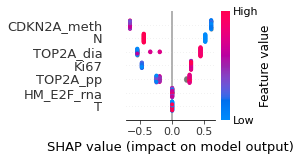

In [8]:
import shap
model = lgb.LGBMClassifier(random_state=1, \
                           n_estimators=pd.DataFrame(aucs).applymap(sum).T['omics'].idxmax()[0], \
                           learning_rate=pd.DataFrame(aucs).applymap(sum).T['omics'].idxmax()[1])
model.fit(df_train[fs['omics']], df_train['pCR'])

model.booster_.save_model('./models/TN.model')
model = lgb.Booster(model_file='./models/TN.model')
model.params['objective'] = 'binary'

explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(df_train[fs['omics']])
plt.gca()
shap.summary_plot(shap_values[1], df_train[fs['omics']], plot_size=[2,2], show=False, plot_type="dot")
# plt.savefig('../figures/shap_tn_combined.pdf', bbox_inches='tight')

Retrain the optimized model combining TransNEO:

In [9]:
df_train = pd.concat([df_tnbc, df_transneo])

100-repeated 5-fold cross-validation:

In [10]:
kf = RepeatedKFold(n_splits=5, n_repeats=100, random_state=1)

fs = {}
fs['clin'] = 'T	N	Ki67'.split('\t')
fs['omics'] = 'T	N	Ki67	CDKN2A_meth	HM_E2F_rna	TOP2A_dia	TOP2A_pp'.split('\t')
fs['single.meth'] = 'CDKN2A_meth'.split('\t')
fs['single.rna'] = 'HM_E2F_rna'.split('\t')
fs['single.prot'] = 'TOP2A_dia	TOP2A_pp'.split('\t')

aucs = {}
aps = {}
for n_est in [50,100,200]:
    for l_rate in [0.05,0.1,0.2]:
        aucs[(n_est, l_rate)] = {}
        aps[(n_est, l_rate)] = {}
        for f in fs.keys():
            aucs[(n_est, l_rate)][f] = []
            aps[(n_est, l_rate)][f] = []
    
for n_est in [50,100,200]:
    for l_rate in [0.05,0.1,0.2]:
        for train_index, test_index in kf.split(df_train):
            X_train, X_test = df_train.drop(columns='pCR').iloc[list(train_index)], df_train.drop(columns='pCR').iloc[list(test_index)]
            y_train, y_test = df_train['pCR'].iloc[list(train_index)], df_train['pCR'].iloc[list(test_index)]
            if y_train.unique().shape[0]==2 and y_test.unique().shape[0]==2:
                for f in fs.keys():
                    model = lgb.LGBMClassifier(random_state=1, n_estimators=n_est, learning_rate=l_rate)
                    model.fit(X_train[fs[f]], y_train)
                    X_test[f] = [i[1] for i in model.predict_proba(X_test[fs[f]])]
                    aucs[(n_est, l_rate)][f].append(roc_auc_score(y_test,X_test[f]))
                    aps[(n_est, l_rate)][f].append(average_precision_score(y_test,X_test[f]))
                
def best_params(res, fs):
    best_pdict = {}
    for i in fs:
        best_pdict[i] = pd.DataFrame(res).applymap(sum).T.sort_values(i).index[-1]
    return pd.concat([pd.DataFrame(res[best_pdict[i]]).melt().loc[pd.DataFrame(res[best_pdict[i]]).melt()['variable']==i] for i in fs])

In [11]:
model = lgb.LGBMClassifier(random_state=1, \
                           n_estimators=pd.DataFrame(aucs).applymap(sum).T['omics'].idxmax()[0], \
                           learning_rate=pd.DataFrame(aucs).applymap(sum).T['omics'].idxmax()[1])
model.fit(df_train[fs['omics']], df_train['pCR'])
model.booster_.save_model('./models/TN_combined.model')
model = lgb.Booster(model_file='./models/TN_combined.model')
model.params['objective'] = 'binary'

Updated threshold: 20%	P value = 0.0020020345735220478
Updated threshold: 30%	P value = 0.0013587277698406696
# of pCR cases 102
# of RD cases 47


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          10.26 <0.005      9.52

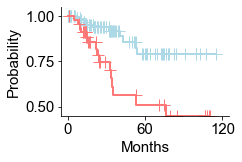

In [12]:
f = 'Pr'
df_tcga = df_tcga.dropna(subset=['MONTHS','STATUS'])
df_tcga[f] = model.predict(df_tcga[fs['omics']])

from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
from lifelines.statistics import logrank_test

def find_best_cutoff_dfs(df,y):
    from lifelines import KaplanMeierFitter
    kmf = KaplanMeierFitter()
    from lifelines.statistics import logrank_test
    cutoff = y.median()
    best_p = 1
    for ii in range(1,10):
        i = 0.1*ii
        tmp_high = df.loc[df[f]>=i,]
        tmp_low = df.loc[df[f]<i,]
        test = logrank_test(tmp_high['MONTHS'].astype(float), \
                               tmp_low['MONTHS'].astype(float), \
                               event_observed_A=tmp_high['STATUS'], \
                               event_observed_B=tmp_low['STATUS'])
        if test.p_value < best_p:
            print('Updated threshold: '+str(int(i*100))+'%\tP value =', test.p_value)
            best_p = test.p_value
            cutoff = i
            
    return cutoff

best_cutoff = find_best_cutoff_dfs(df_tcga,df_tcga[f])

tmp_high = df_tcga.loc[df_tcga[f]>=best_cutoff,]
tmp_low = df_tcga.loc[df_tcga[f]<best_cutoff,]


label_size = 15
plt.rcParams['font.family'] = 'arial'
plt.rcParams['xtick.labelsize'] = label_size 
plt.rcParams['ytick.labelsize'] = label_size
fig, ax = plt.subplots(figsize=[3,2])

kmf.fit(tmp_high['MONTHS'], \
        event_observed=tmp_high['STATUS'], \
        label='High')
kmf.plot(ax=ax, linewidth=2, color='lightblue', ci_show=False, show_censors=True)

kmf.fit(tmp_low['MONTHS'], \
        event_observed=tmp_low['STATUS'], \
        label='Low')
kmf.plot(ax=ax, linewidth=2, color='#ff7878', ci_show=False, show_censors=True)

print('# of pCR cases',tmp_high.shape[0])
print('# of RD cases',tmp_low.shape[0])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_legend().remove()
plt.xlabel('Months', fontsize=label_size)
plt.ylabel('Probability', fontsize=label_size)

plt.yticks([0.5,0.75,1])
plt.ylim([0.45,1.05])
plt.xticks([0,60,120])
plt.xlim([-5,125])

results = logrank_test(tmp_high['MONTHS'].astype(float), \
                       tmp_low['MONTHS'].astype(float), \
                       event_observed_A=tmp_high['STATUS'], \
                       event_observed_B=tmp_low['STATUS'])
results.print_summary()
plt.savefig('../figures/tcga_tn_combined.pdf', bbox_inches='tight')

Updated threshold: 20%	P value = 0.024617225257288947
Updated threshold: 70%	P value = 0.022861535079061333
# of pCR cases 81
# of RD cases 384


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           5.18 0.02      5.45

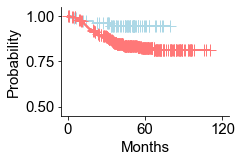

In [13]:
f = 'Pr'

df_fuscc = pd.read_csv('./results/fuscc_clin.NN.prediction.csv', index_col=0)
df_fuscc

df_fuscc = df_fuscc.dropna(subset=['MONTHS','STATUS'])
df_fuscc[f] = model.predict(df_fuscc[fs['omics']])

from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
from lifelines.statistics import logrank_test

def find_best_cutoff_dfs(df,y):
    from lifelines import KaplanMeierFitter
    kmf = KaplanMeierFitter()
    from lifelines.statistics import logrank_test
    cutoff = y.median()
    best_p = 1
    for ii in range(1,10):
        i = 0.1*ii
        tmp_high = df.loc[df[f]>=i,]
        tmp_low = df.loc[df[f]<i,]
        test = logrank_test(tmp_high['MONTHS'].astype(float), \
                               tmp_low['MONTHS'].astype(float), \
                               event_observed_A=tmp_high['STATUS'], \
                               event_observed_B=tmp_low['STATUS'])
        if test.p_value < best_p:
            print('Updated threshold: '+str(int(i*100))+'%\tP value =', test.p_value)
            best_p = test.p_value
            cutoff = i
            
    return cutoff

best_cutoff = find_best_cutoff_dfs(df_fuscc,df_fuscc[f])

tmp_high = df_fuscc.loc[df_fuscc[f]>=best_cutoff,]
tmp_low = df_fuscc.loc[df_fuscc[f]<best_cutoff,]


label_size = 15
plt.rcParams['font.family'] = 'arial'
plt.rcParams['xtick.labelsize'] = label_size 
plt.rcParams['ytick.labelsize'] = label_size
fig, ax = plt.subplots(figsize=[3,2])

kmf.fit(tmp_high['MONTHS'], \
        event_observed=tmp_high['STATUS'], \
        label='High')
kmf.plot(ax=ax, linewidth=2, color='lightblue', ci_show=False, show_censors=True)

kmf.fit(tmp_low['MONTHS'], \
        event_observed=tmp_low['STATUS'], \
        label='Low')
kmf.plot(ax=ax, linewidth=2, color='#ff7878', ci_show=False, show_censors=True)

print('# of pCR cases',tmp_high.shape[0])
print('# of RD cases',tmp_low.shape[0])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_legend().remove()
plt.xlabel('Months', fontsize=label_size)
plt.ylabel('Probability', fontsize=label_size)

plt.yticks([0.5,0.75,1])
plt.ylim([0.45,1.05])
plt.xticks([0,60,120])
plt.xlim([-5,125])

results = logrank_test(tmp_high['MONTHS'].astype(float), \
                       tmp_low['MONTHS'].astype(float), \
                       event_observed_A=tmp_high['STATUS'], \
                       event_observed_B=tmp_low['STATUS'])
results.print_summary()
plt.savefig('../figures/fuscc_tn_combined.pdf', bbox_inches='tight')

dash 0.7333333333333334
0.8333333333333334
dash 0.5824648162768367
0.7959214963780181


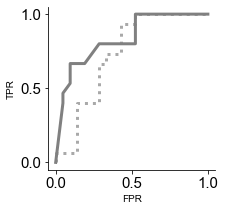

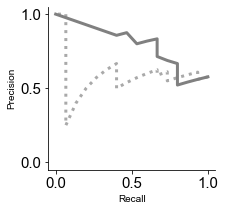

In [14]:
from sklearn import metrics
f, ax = plt.subplots(figsize=[3,3])
fpr, tpr, threshold = metrics.roc_curve(df_transneo['pCR'],df_transneo.index.map(pd.read_csv('https://github.com/cclab-brca/neoadjuvant-therapy-response-predictor\
/raw/master/data/transneo-diagnosis-MLscores.tsv.gz',sep='\t', index_col=0)['Integrated model']))
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc, linestyle='dotted', linewidth=3, color='darkgray')
print('dash', roc_auc)
fpr, tpr, threshold = metrics.roc_curve(df_transneo['pCR'],model.predict(df_transneo[fs['omics']]),)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc, linewidth=3, color='gray')
print(roc_auc)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.yticks([0,0.5,1])
plt.xticks([0,0.5,1])

plt.savefig('../figures/transneo_tn_combined.roc.pdf', bbox_inches='tight')

f, ax = plt.subplots(figsize=[3,3])
p, r, threshold = metrics.precision_recall_curve(df_transneo['pCR'],df_transneo.index.map(pd.read_csv('https://github.com/cclab-brca/neoadjuvant-therapy-response-predictor\
/raw/master/data/transneo-diagnosis-MLscores.tsv.gz',sep='\t', index_col=0)['Integrated model']))
prc_auc = metrics.auc(r, p)
plt.plot(r, p,  linestyle='dotted', linewidth=3, color='darkgray')
print('dash', prc_auc)
p, r, threshold = metrics.precision_recall_curve(df_transneo['pCR'],model.predict(df_transneo[fs['omics']]),)
prc_auc = metrics.auc(r, p)
print(prc_auc)
plt.plot(r, p,  linewidth=3, color='gray')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.legend()
plt.xlabel('Recall')
plt.ylim([-.05,1.05])
plt.yticks([0,0.5,1])
plt.xticks([0,0.5,1])
plt.ylabel('Precision')
plt.savefig('../figures/transneo_tn_combined.prc.pdf', bbox_inches='tight')

0.7224157955865274
0.6345185281757495


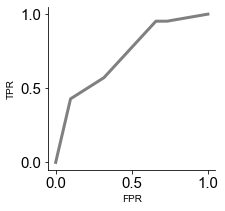

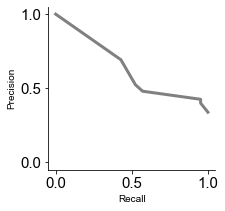

In [15]:
pyro_tn = pd.read_csv('./results/pyro_clin.NN.prediction.csv', index_col=0)
pyro_tn['pCR'] = pyro_tn.index.map(pd.read_csv('./data/pyro_clin.csv', index_col=0)['pCR'])
pyro_tn['NN'] = model.predict(pyro_tn[fs['omics']])

f, ax = plt.subplots(figsize=[3,3])
fpr, tpr, threshold = metrics.roc_curve(pyro_tn['pCR'], pyro_tn['NN'])
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc, linewidth=3, color='gray')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
print(roc_auc)
# plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.yticks([0,0.5,1])
plt.xticks([0,0.5,1])

plt.savefig('../figures/pyro_combined.roc.pdf', bbox_inches='tight')

f, ax = plt.subplots(figsize=[3,3])
p, r, threshold = metrics.precision_recall_curve(pyro_tn['pCR'], pyro_tn['NN'])
prc_auc = metrics.auc(r, p)
plt.plot(r, p, label = 'AUPRC = %0.2f' % prc_auc, linewidth=3, color='gray')

print(prc_auc)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.legend()
plt.xlabel('Recall')
plt.ylim([-.05,1.05])
plt.yticks([0,0.5,1])
plt.xticks([0,0.5,1])
plt.ylabel('Precision')

plt.savefig('../figures/pyro_combined.prc.pdf', bbox_inches='tight')